In [123]:
import os
import sys

import torch.nn as nn
import torch.nn.init as init

In [ ]:
#ResNet18 Model
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):

        out = F.relu(self.bn1(self.conv1(x)))

        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64


        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


In [ ]:
#Checking Size Of sample feed forward output
def test():
    net = ResNet18()
    y = net(torch.randn(1, 3, 32, 32))
    print(y.size())

test()

torch.Size([1, 10])


In [ ]:
#Defining Transformations
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse


device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


==> Preparing data..


In [ ]:
#Loading Dataset and DataLoader
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)


trainset,validationset=torch.utils.data.random_split(trainset,[40000,10000])

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=60, shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(
    validationset, batch_size=60, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Defining instance of ResNet18 model, Loss function, Optimizer and Scheduler
net = ResNet18()
net = net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)

In [ ]:
#Training Loop
def train(ep):
  net.eval()
  net.train()
  losses=[]
  for epoch in range(ep):
    running_loss=0
    for i,data in enumerate(trainloader,0):
      inputs,labels=data
      inputs,labels=inputs.to(device),labels.to(device)
      optimizer.zero_grad()
      outputs=net(inputs)
      loss=criterion(outputs,labels)
      loss.backward()
      optimizer.step()
      scheduler.step()
      running_loss+=loss.item()
      if((i+1)%20==0):
        losses.append(running_loss/20)
        print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 20:.3f}')
        running_loss = 0.0
    
  return losses


In [ ]:
losses=train(100)

[1,    20] loss: 1.502
[1,    40] loss: 1.521
[1,    60] loss: 1.478
[1,    80] loss: 1.487
[1,   100] loss: 1.430
[1,   120] loss: 1.425
[1,   140] loss: 1.408
[1,   160] loss: 1.328
[1,   180] loss: 1.373
[1,   200] loss: 1.367
[1,   220] loss: 1.314
[1,   240] loss: 1.302
[1,   260] loss: 1.336
[1,   280] loss: 1.273
[1,   300] loss: 1.314
[1,   320] loss: 1.310
[1,   340] loss: 1.272
[1,   360] loss: 1.264
[1,   380] loss: 1.255
[1,   400] loss: 1.278
[1,   420] loss: 1.270
[1,   440] loss: 1.262
[1,   460] loss: 1.305
[1,   480] loss: 1.326
[1,   500] loss: 1.326
[1,   520] loss: 1.292
[1,   540] loss: 1.348
[1,   560] loss: 1.361
[1,   580] loss: 1.231
[1,   600] loss: 1.313
[1,   620] loss: 1.282
[1,   640] loss: 1.298
[1,   660] loss: 1.233
[2,    20] loss: 1.216
[2,    40] loss: 1.180
[2,    60] loss: 1.195
[2,    80] loss: 1.153
[2,   100] loss: 1.157
[2,   120] loss: 1.175
[2,   140] loss: 1.190
[2,   160] loss: 1.115
[2,   180] loss: 1.034
[2,   200] loss: 1.047
[2,   220] 

In [ ]:
#Checking dimension of Losses
print(len(losses))

3300


Text(0, 0.5, 'Loss')

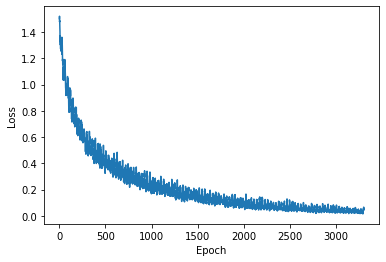

In [100]:
#Plotting Loss over Epochs in Training
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.linspace(1, len(losses), len(losses)), losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [101]:
#Saving updated parameters
PATH='.cifar_path'
torch.save(net.state_dict(),PATH)

In [111]:
#Creating instance to check accuracy over validation set
net1=ResNet18()

net1.load_state_dict(torch.load(PATH))


<All keys matched successfully>

In [121]:
#Testing Validation Set
correct = 0
total = 0

with torch.no_grad():
    for data in validationloader:
        images, labels = data

        outputs = net1(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 88 %


In [124]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 88.4 %
Accuracy for class: car   is 94.5 %
Accuracy for class: bird  is 82.0 %
Accuracy for class: cat   is 72.7 %
Accuracy for class: deer  is 87.7 %
Accuracy for class: dog   is 85.1 %
Accuracy for class: frog  is 92.4 %
Accuracy for class: horse is 90.6 %
Accuracy for class: ship  is 93.2 %
Accuracy for class: truck is 92.8 %
